In [1]:
import torch
from torch import nn
import numpy as np
import os
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_inline import backend_inline
import time
import math

In [2]:
backend_inline.set_matplotlib_formats("svg")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


class MLP(nn.Module):
    def __init__(self, lst: list, act: callable = nn.Tanh):
        super().__init__()
        depth = len(lst) - 1
        layer = []
        for i in range(depth - 1):
            linear = nn.Linear(lst[i], lst[i + 1])
            layer.append(linear)
            layer.append(act())
        layer.append(nn.Linear(lst[-2], lst[-1]))
        self.layer = nn.Sequential(*layer)

    def forward(self, X):
        return self.layer(X)


model = MLP([2] + [50] * 4 + [1]).cuda()

In [3]:
# --------------- Equation Config ----------------------
# os.chdir("./model_save")
# path = "./model_save"
k0 = 4 * math.pi


def _u(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])

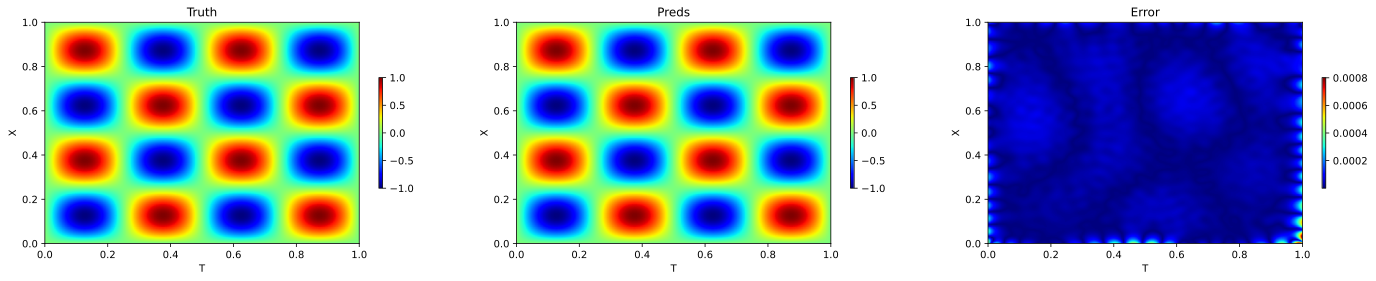

In [4]:
model.load_state_dict(torch.load("Best.pt"))
p = np.linspace(0, 1, 201)
q = np.linspace(0, 1, 201)
P, Q = np.meshgrid(p, q, indexing="ij")
datasets = np.concatenate([P.flatten()[:, None], Q.flatten()[:, None]], 1)
Truth = np.sin(k0 * P) * np.sin(k0 * Q)
preds = (
    model(torch.tensor(data=datasets, dtype=torch.float32).cuda())
    .cpu()
    .detach()
    .numpy()
    .reshape(201, 201)
)
extent = [0, 1, 0, 1]

figs, ax = plt.subplots(1, 3, figsize=(24, 4))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]

h1 = ax1.imshow(Truth, cmap="jet", aspect="auto", extent=extent)
ax1.set_title("Truth")
ax1.set_xlabel("T")
ax1.set_ylabel("X")
figs.colorbar(h1, ax=ax1, shrink=0.5, aspect=30, pad=0.05)


h2 = ax2.imshow(preds, cmap="jet", aspect="auto", extent=extent)
ax2.set_title("Preds")
ax2.set_xlabel("T")
ax2.set_ylabel("X")
figs.colorbar(h2, ax=ax2, shrink=0.5, aspect=30, pad=0.05)


h3 = ax3.imshow(np.abs(Truth - preds), cmap="jet", aspect="auto", extent=extent)
ax3.set_title("Error")
ax3.set_xlabel("T")
ax3.set_ylabel("X")
figs.colorbar(h3, ax=ax3, shrink=0.5, aspect=30, pad=0.05)
plt.show()

# 图像绘制

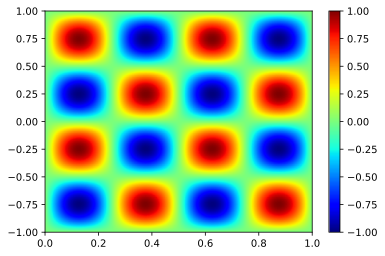

In [5]:
# 保存图像
fig = plt.figure(figsize=(6, 4))
Preds = fig.add_subplot(111)
# =======================================================

h1 = Preds.imshow(preds, cmap="jet", aspect="auto", extent=[0, 1, -1, 1])
fig.colorbar(h1, ax=Preds)
plt.show()

In [6]:
# weights = np.load("../col_weights.npy")
# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111)
# h = ax.imshow(weights, extent=[0, 1, 0, 1], aspect="auto", cmap="jet")
# fig.colorbar(h, ax=ax)

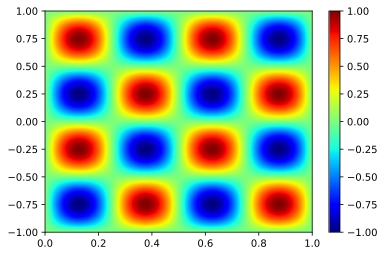

In [7]:
# =======================================================
fig = plt.figure(figsize=(6, 4))
Trues = fig.add_subplot(111)

h2 = Trues.imshow(Truth, cmap="jet", aspect="auto", extent=[0, 1, -1, 1])
fig.colorbar(h2, ax=Trues)
plt.show()

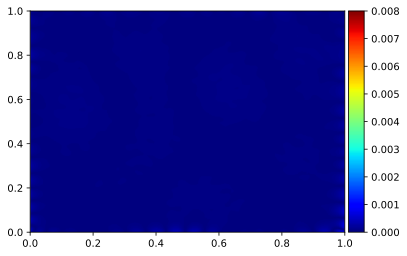

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

error = np.abs(Truth - preds)
fig, ax = plt.subplots(figsize=(6, 4))
h = ax.imshow(
    error, cmap="jet", extent=[0, 1, 0, 1], aspect="auto", vmin=0.0, vmax=0.008
)  # 用左边 colorbar 的最大值)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
plt.savefig("Ours.pdf")
plt.show()

In [9]:
rel2 = np.linalg.norm(Truth - preds, 2) / np.linalg.norm(Truth, 2)
print("ReL2: ", rel2)

ReL2:  6.0105328505925704e-05


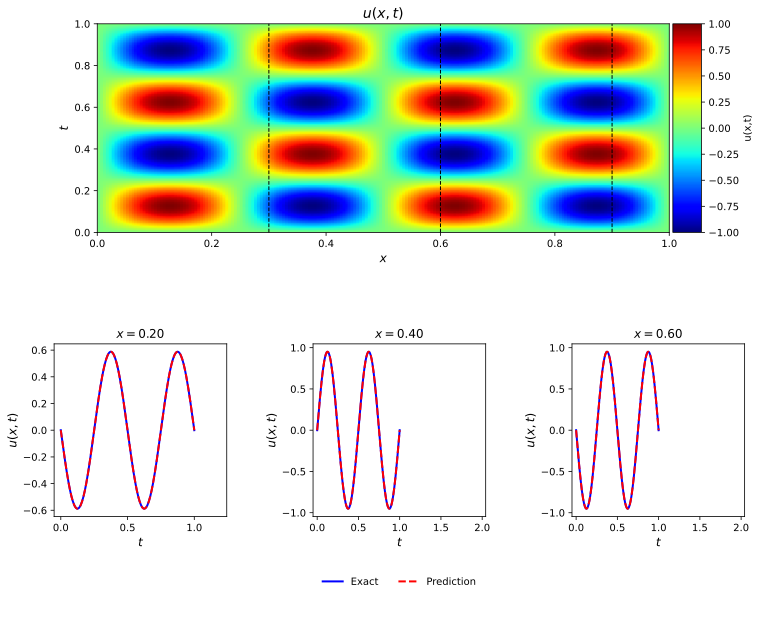

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


U_pred = preds
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.94, bottom=0.65, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(
    U_pred,
    interpolation="nearest",
    cmap="jet",  # 更具吸引力的色彩映射
    extent=[0, 1, 0, 1],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax)
cbar.set_label("u(x,t)", fontsize=10)  # 为颜色栏添加标签

line = np.linspace(p.min(), p.max(), 2)[:, None]
ax.plot(q[60] * np.ones((2, 1)), line, "k--", linewidth=1)
ax.plot(q[120] * np.ones((2, 1)), line, "k--", linewidth=1)
ax.plot(q[180] * np.ones((2, 1)), line, "k--", linewidth=1)

ax.set_xlabel("$x$", fontsize=12)
ax.set_ylabel("$t$", fontsize=12)
ax.set_title("$u(x,t)$", fontsize=14)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.6, bottom=0.15, left=0.1, right=0.9, wspace=0.5)

# 三个子图
x_indices = [60, 120, 180]
for i, idx in enumerate(x_indices):
    ax = plt.subplot(gs1[0, i])
    ax.plot(p, Truth[:, idx], "b-", linewidth=2, label="Exact")
    ax.plot(p, U_pred[:, idx], "r--", linewidth=2, label="Prediction")
    ax.set_xlabel("$t$", fontsize=12)
    ax.set_ylabel("$u(x,t)$", fontsize=12)
    ax.set_title(f"$x = {x_indices[i]/301:.2f}$", fontsize=12)
    ax.axis("square")
    ax.set_xlim([0.1, 1.1])
    # ax.set_ylim([0.1, 1.1])
    plt.axis("square")

    if i == 1:
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.3),
            ncol=2,
            frameon=False,
            fontsize=10,
        )

plt.show()